# Check OS

In [ ]:
!lsb_release -a

In [ ]:
!sudo apt install tree

# View Dataset Details

In [ ]:
!tree --dirsfirst --filelimit 5 "./contour_images"

In [67]:
import os
import glob

base_dir = os.path.join('./contour_images')
infected_dir = os.path.join(base_dir,'Good')
healthy_dir = os.path.join(base_dir,'Bad')

infected_files = glob.glob(infected_dir+'/*.png')
healthy_files = glob.glob(healthy_dir+'/*.png')
len(infected_files), len(healthy_files)

(182, 183)

In [68]:
import numpy as np
import pandas as pd

np.random.seed(42)

files_df = pd.DataFrame({
    'filename': infected_files + healthy_files,
    'label': [' bad'] * len(infected_files) + [' good'] * len(healthy_files)
}).sample(frac=1, random_state=42).reset_index(drop=True)

files_df.head()

,filename,label
0,./contour_images\Bad\lpgood010.PNG,good
1,./contour_images\Good\lpbad032.PNG,bad
2,./contour_images\Good\lpbad014.PNG,bad
3,./contour_images\Bad\lpgood125.PNG,good
4,./contour_images\Good\lpbad056.PNG,bad


# Create Train, Validation and Test Datasets

In [69]:
from sklearn.model_selection import train_test_split
from collections import Counter

train_files, test_files, train_labels, test_labels = train_test_split(files_df['filename'].values,
                                                                      files_df['label'].values, 
                                                                      test_size=0.3, random_state=42)
train_files, val_files, train_labels, val_labels = train_test_split(train_files,
                                                                    train_labels, 
                                                                    test_size=0.1, random_state=42)

print(train_files.shape, val_files.shape, test_files.shape)
print('Train:', Counter(train_labels), '\nVal:', Counter(val_labels), '\nTest:', Counter(test_labels))

(229,) (26,) (110,)
Train: Counter({' bad': 120, ' good': 109}) 
Val: Counter({' good': 16, ' bad': 10}) 
Test: Counter({' good': 58, ' bad': 52})


## Get Image Dimension Summary Stats

In [70]:
import cv2
from concurrent import futures
import threading

def get_img_shape_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    return cv2.imread(img).shape
  
ex = futures.ThreadPoolExecutor(max_workers=None)
data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
print('Starting Img shape computation:')
train_img_dims_map = ex.map(get_img_shape_parallel, 
                            [record[0] for record in data_inp],
                            [record[1] for record in data_inp],
                            [record[2] for record in data_inp])
train_img_dims = list(train_img_dims_map)
print('Min Dimensions:', np.min(train_img_dims, axis=0)) 
print('Avg Dimensions:', np.mean(train_img_dims, axis=0))
print('Median Dimensions:', np.median(train_img_dims, axis=0))
print('Max Dimensions:', np.max(train_img_dims, axis=0))

Starting Img shape computation:
ThreadPoolExecutor-4_0: working on img num: 0
ThreadPoolExecutor-4_2: working on img num: 228
Min Dimensions: [69 70  3]
Avg Dimensions: [180.09170306 199.04803493   3.        ]
Median Dimensions: [167. 178.   3.]
Max Dimensions: [449 432   3]


## Load and Resize Images

In [71]:
IMG_DIMS = (125, 125)

def get_img_data_parallel(idx, img, total_imgs):
    if idx % 5000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    img = cv2.imread(img)
    img = cv2.resize(img, dsize=IMG_DIMS, 
                     interpolation=cv2.INTER_CUBIC)
    img = np.array(img, dtype=np.float32)
    return img

ex = futures.ThreadPoolExecutor(max_workers=None)
train_data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
val_data_inp = [(idx, img, len(val_files)) for idx, img in enumerate(val_files)]
test_data_inp = [(idx, img, len(test_files)) for idx, img in enumerate(test_files)]

print('Loading Train Images:')
train_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in train_data_inp],
                        [record[1] for record in train_data_inp],
                        [record[2] for record in train_data_inp])
train_data = np.array(list(train_data_map))

print('\nLoading Validation Images:')
val_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in val_data_inp],
                        [record[1] for record in val_data_inp],
                        [record[2] for record in val_data_inp])
val_data = np.array(list(val_data_map))

print('\nLoading Test Images:')
test_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in test_data_inp],
                        [record[1] for record in test_data_inp],
                        [record[2] for record in test_data_inp])
test_data = np.array(list(test_data_map))

train_data.shape, val_data.shape, test_data.shape  

Loading Train Images:
ThreadPoolExecutor-5_0: working on img num: 0
ThreadPoolExecutor-5_6: working on img num: 228

Loading Validation Images:
ThreadPoolExecutor-5_7: working on img num: 0
ThreadPoolExecutor-5_7: working on img num: 25

Loading Test Images:
ThreadPoolExecutor-5_18: working on img num: 0
ThreadPoolExecutor-5_3: working on img num: 109


((229, 125, 125, 3), (26, 125, 125, 3), (110, 125, 125, 3))

# View Sample Cell Images

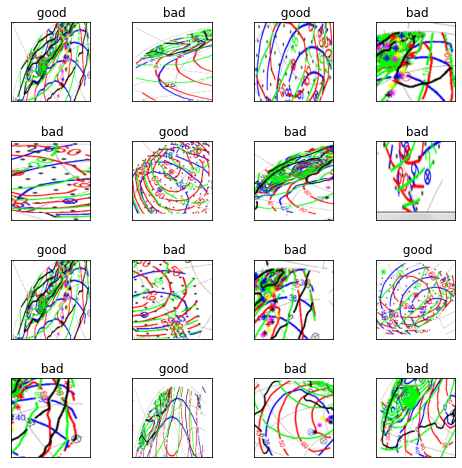

In [72]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1 , figsize = (8 , 8))
n = 0 
for i in range(16):
    n += 1 
    r = np.random.randint(0 , train_data.shape[0] , 1)
    plt.subplot(4 , 4 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(train_data[r[0]]/255.)
    plt.title('{}'.format(train_labels[r[0]]))
    plt.xticks([]) , plt.yticks([])

# Setup config settings, Scale Images & Label encode classes

In [73]:
#BATCH_SIZE = 64
#BATCH_SIZE = 32
BATCH_SIZE = 16
NUM_CLASSES = 2
#EPOCHS = 25
EPOCHS = 25
INPUT_SHAPE = (125, 125, 3)

train_imgs_scaled = train_data / 255.
val_imgs_scaled = val_data / 255.

# encode text category labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
val_labels_enc = le.transform(val_labels)

print(train_labels[:6], train_labels_enc[:6])

[' good' ' good' ' bad' ' bad' ' bad' ' bad'] [1 1 0 0 0 0]


In [74]:
import tensorflow as tf

# Load the TensorBoard notebook extension (optional)
%load_ext tensorboard

#tf.random.set_seed(42)
tf.__version__

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


'1.14.0'

# Model 1: CNN from Scratch

## Build Model Architecture

In [75]:
inp = tf.keras.layers.Input(shape=INPUT_SHAPE)

conv1 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), 
                               activation='relu', padding='same')(inp)
pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), 
                               activation='relu', padding='same')(pool1)
pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), 
                               activation='relu', padding='same')(pool2)
pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

flat = tf.keras.layers.Flatten()(pool3)

hidden1 = tf.keras.layers.Dense(512, activation='relu')(flat)
drop1 = tf.keras.layers.Dropout(rate=0.3)(hidden1)
hidden2 = tf.keras.layers.Dense(512, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.3)(hidden2)

out = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.Model(inputs=inp, outputs=out)
model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics=['accuracy'])
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 125, 125, 3)]     0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 125, 125, 32)      896       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 62, 62, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 31, 31, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 15, 15, 128)       0   

## Train Model

In [76]:
import datetime

#logdir = os.path.join('/home/dipanzan_sarkar/projects/tensorboard_logs', 
#                      datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
#tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
#                              patience=2, min_lr=0.000001)

#early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, 
#                                              mode='auto', baseline=None, restore_best_weights=False)
#callbacks = [reduce_lr, tensorboard_callback]

history = model.fit(x=train_imgs_scaled, y=train_labels_enc, 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, 
                    validation_data=(val_imgs_scaled, val_labels_enc), 
#                    callbacks=callbacks,
                    verbose=1)

Train on 229 samples, validate on 26 samples
Epoch 1/25
229/229 [==============================] - 10s 43ms/sample - loss: 0.8688 - acc: 0.4541 - val_loss: 0.6926 - val_acc: 0.4231
Epoch 2/25
229/229 [==============================] - 6s 28ms/sample - loss: 0.6944 - acc: 0.4847 - val_loss: 0.6950 - val_acc: 0.3846
Epoch 3/25
229/229 [==============================] - 7s 31ms/sample - loss: 0.6883 - acc: 0.5328 - val_loss: 0.6998 - val_acc: 0.3846
Epoch 4/25
229/229 [==============================] - 7s 29ms/sample - loss: 0.6800 - acc: 0.5721 - val_loss: 0.6575 - val_acc: 0.8077
Epoch 5/25
229/229 [==============================] - 7s 29ms/sample - loss: 0.6110 - acc: 0.7118 - val_loss: 0.5590 - val_acc: 0.7308
Epoch 6/25
229/229 [==============================] - 7s 31ms/sample - loss: 0.4784 - acc: 0.7642 - val_loss: 0.6113 - val_acc: 0.6154
Epoch 7/25
229/229 [==============================] - 7s 29ms/sample - loss: 0.4752 - acc: 0.8035 - val_loss: 0.7085 - val_acc: 0.4615
Epoch 8/2

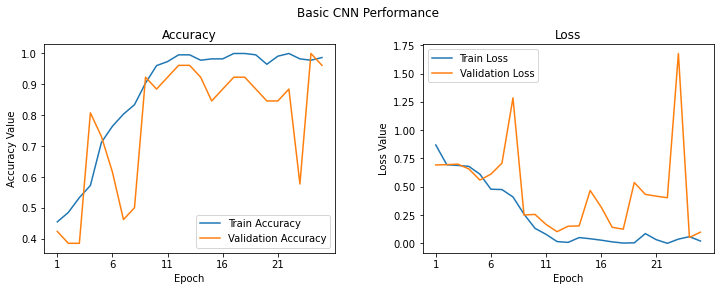

In [77]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

#max_epoch = len(history.history['accuracy'])+1
max_epoch = len(history.history['val_acc'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

## Save Model

In [78]:
model.save('basic_cnn.h5')

# Transfer Learning 
# Model 2: Frozen Pre-trained CNN 

## Build Model Architecture

In [79]:
vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', 
                                        input_shape=INPUT_SHAPE)
vgg.trainable = False
# Freeze the layers
for layer in vgg.layers:
    layer.trainable = False
    
base_vgg = vgg
base_out = base_vgg.output
pool_out = tf.keras.layers.Flatten()(base_out)
hidden1 = tf.keras.layers.Dense(512, activation='relu')(pool_out)
drop1 = tf.keras.layers.Dropout(rate=0.3)(hidden1)
hidden2 = tf.keras.layers.Dense(512, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.3)(hidden2)

out = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.Model(inputs=base_vgg.input, outputs=out)
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-4),
                loss='binary_crossentropy',
                metrics=['accuracy'])
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 125, 125, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 125, 125, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 125, 125, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 62, 62, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 62, 62, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 62, 62, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 31, 31, 128)       0   

In [80]:
print("Total Layers:", len(model.layers))
print("Total trainable layers:", sum([1 for l in model.layers if l.trainable]))

Total Layers: 28
Total trainable layers: 6


## Train Model

In [81]:
#tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
#                              patience=2, min_lr=0.000001)

#early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=15, 
#                                              mode='auto', baseline=None, restore_best_weights=False)
#callbacks = [reduce_lr, tensorboard_callback]

history = model.fit(x=train_imgs_scaled, y=train_labels_enc, 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, 
                    validation_data=(val_imgs_scaled, val_labels_enc), 
#                   callbacks=callbacks,
                    verbose=1)

Train on 229 samples, validate on 26 samples
Epoch 1/25
229/229 [==============================] - 26s 113ms/sample - loss: 0.6954 - acc: 0.6114 - val_loss: 0.7027 - val_acc: 0.3846
Epoch 2/25
229/229 [==============================] - 22s 96ms/sample - loss: 0.5184 - acc: 0.7555 - val_loss: 0.4465 - val_acc: 0.7692
Epoch 3/25
229/229 [==============================] - 24s 104ms/sample - loss: 0.4396 - acc: 0.8122 - val_loss: 0.4193 - val_acc: 0.7692
Epoch 4/25
229/229 [==============================] - 24s 105ms/sample - loss: 0.3560 - acc: 0.8472 - val_loss: 0.3113 - val_acc: 0.9615
Epoch 5/25
229/229 [==============================] - 24s 104ms/sample - loss: 0.2840 - acc: 0.9214 - val_loss: 0.2953 - val_acc: 0.9615
Epoch 6/25
229/229 [==============================] - 24s 106ms/sample - loss: 0.2167 - acc: 0.9432 - val_loss: 0.2430 - val_acc: 0.9231
Epoch 7/25
229/229 [==============================] - 24s 104ms/sample - loss: 0.1931 - acc: 0.9563 - val_loss: 0.1942 - val_acc: 0.92

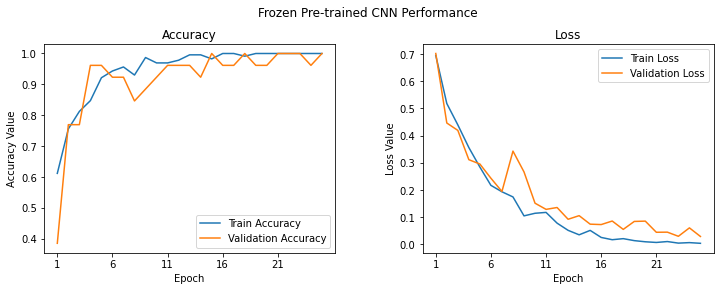

In [82]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Frozen Pre-trained CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['val_acc'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

## Save Model

In [83]:
model.save('vgg_frozen.h5')

# Build Image Augmentors

In [84]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                zoom_range=0.05, 
                                                                rotation_range=25,
                                                                width_shift_range=0.05, 
                                                                height_shift_range=0.05, 
                                                                shear_range=0.05, horizontal_flip=True, 
                                                                fill_mode='nearest')

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

Labels: [' good', ' good', ' good', ' good', ' good']


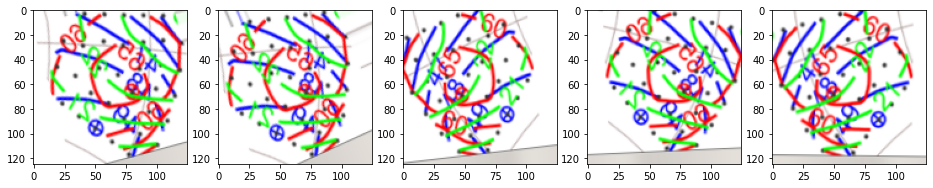

In [85]:
img_id = 0
sample_generator = train_datagen.flow(train_data[img_id:img_id+1], train_labels[img_id:img_id+1],
                                      batch_size=1)
sample = [next(sample_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in sample])
l = [ax[i].imshow(sample[i][0][0]) for i in range(0,5)]

In [86]:
train_generator = train_datagen.flow(train_data, train_labels_enc, batch_size=BATCH_SIZE, shuffle=True)
val_generator = val_datagen.flow(val_data, val_labels_enc, batch_size=BATCH_SIZE, shuffle=False)

# Transfer Learning 
# Model 3: Fine-tuned Pre-trained CNN with Image Augmentation 

## Build Model Architecture

In [87]:
vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet', 
                                        input_shape=INPUT_SHAPE)
# Freeze the layers
vgg.trainable = True

set_trainable = False
for layer in vgg.layers:
    if layer.name in ['block5_conv1', 'block4_conv1']:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
    
base_vgg = vgg
base_out = base_vgg.output
pool_out = tf.keras.layers.Flatten()(base_out)
hidden1 = tf.keras.layers.Dense(512, activation='relu')(pool_out)
drop1 = tf.keras.layers.Dropout(rate=0.3)(hidden1)
hidden2 = tf.keras.layers.Dense(512, activation='relu')(drop1)
drop2 = tf.keras.layers.Dropout(rate=0.3)(hidden2)

out = tf.keras.layers.Dense(1, activation='sigmoid')(drop2)

model = tf.keras.Model(inputs=base_vgg.input, outputs=out)
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=1e-5),
                loss='binary_crossentropy',
                metrics=['accuracy'])

print("Total Layers:", len(model.layers))
print("Total trainable layers:", sum([1 for l in model.layers if l.trainable]))

Total Layers: 28
Total trainable layers: 16


## Train Model

In [90]:
#tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
#                              patience=2, min_lr=0.000001)

#early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=15, 
#                                              mode='auto', baseline=None, restore_best_weights=False)
#callbacks = [reduce_lr, tensorboard_callback]
train_steps_per_epoch = train_generator.n // train_generator.batch_size
val_steps_per_epoch = val_generator.n // val_generator.batch_size
#val_steps_per_epoch = 1

In [91]:
print (train_steps_per_epoch, val_steps_per_epoch)

14 1


In [92]:
#tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
#reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
#                              patience=2, min_lr=0.000001)

#early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=15, 
#                                              mode='auto', baseline=None, restore_best_weights=False)
#callbacks = [reduce_lr, tensorboard_callback]
train_steps_per_epoch = train_generator.n // train_generator.batch_size
val_steps_per_epoch = val_generator.n // val_generator.batch_size
#val_steps_per_epoch = 1
history = model.fit_generator(train_generator, steps_per_epoch=train_steps_per_epoch, epochs=EPOCHS,
                              validation_data=val_generator, validation_steps=val_steps_per_epoch, 
                              verbose=1)

Epoch 1/25
14/14 [==============================] - 57s 4s/step - loss: 0.7264 - acc: 0.5587 - val_loss: 0.6157 - val_acc: 0.8125
Epoch 2/25
14/14 [==============================] - 52s 4s/step - loss: 0.6574 - acc: 0.6071 - val_loss: 0.5028 - val_acc: 0.8750
Epoch 3/25
14/14 [==============================] - 47s 3s/step - loss: 0.4558 - acc: 0.7822 - val_loss: 0.4562 - val_acc: 0.9375
Epoch 4/25
14/14 [==============================] - 50s 4s/step - loss: 0.3867 - acc: 0.8263 - val_loss: 0.2233 - val_acc: 0.9375
Epoch 5/25
14/14 [==============================] - 54s 4s/step - loss: 0.3573 - acc: 0.8527 - val_loss: 0.2752 - val_acc: 0.9375
Epoch 6/25
14/14 [==============================] - 47s 3s/step - loss: 0.2606 - acc: 0.8960 - val_loss: 0.1627 - val_acc: 0.9375
Epoch 7/25
14/14 [==============================] - 50s 4s/step - loss: 0.2823 - acc: 0.8920 - val_loss: 0.1069 - val_acc: 0.9375
Epoch 8/25
14/14 [==============================] - 52s 4s/step - loss: 0.2227 - acc: 0.93

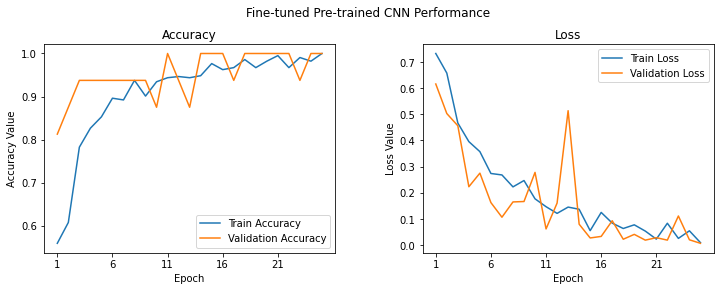

In [93]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Fine-tuned Pre-trained CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

max_epoch = len(history.history['val_acc'])+1
epoch_list = list(range(1,max_epoch))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(1, max_epoch, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(1, max_epoch, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

## Save Model

In [94]:
model.save('vgg_finetuned.h5')

# Model Performance Evaluation

In [95]:
test_imgs_scaled = test_data / 255.
test_imgs_scaled.shape, test_labels.shape

((110, 125, 125, 3), (110,))

In [96]:
! ls -l --block-size=MB | grep .h5

'ls' is not recognized as an internal or external command,
operable program or batch file.


In [97]:
basic_cnn = tf.keras.models.load_model('./basic_cnn.h5')
#vgg_frz = tf.keras.models.load_model('./vgg_frozen.h5')
vgg_ft = tf.keras.models.load_model('./vgg_finetuned.h5')

In [98]:
basic_cnn_preds = basic_cnn.predict(test_imgs_scaled, batch_size=32)
#vgg_frz_preds = vgg_frz.predict(test_imgs_scaled, batch_size=512)
#vgg_ft_preds = vgg_ft.predict(test_imgs_scaled, batch_size=512)

basic_cnn_pred_labels = le.inverse_transform([1 if pred > 0.5 else 0 
                                                  for pred in basic_cnn_preds.ravel()])
#vgg_frz_pred_labels = le.inverse_transform([1 if pred > 0.5 else 0 
#                                                  for pred in vgg_frz_preds.ravel()])
#vgg_ft_pred_labels = le.inverse_transform([1 if pred > 0.5 else 0 
#                                                  for pred in vgg_ft_preds.ravel()])

In [99]:
#basic_cnn = tf.keras.models.load_model('./basic_cnn.h5')
vgg_frz = tf.keras.models.load_model('./vgg_frozen.h5')
#vgg_ft = tf.keras.models.load_model('./vgg_finetuned.h5')

In [100]:
#basic_cnn_preds = basic_cnn.predict(test_imgs_scaled, batch_size=32)
vgg_frz_preds = vgg_frz.predict(test_imgs_scaled, batch_size=32)
#vgg_ft_preds = vgg_ft.predict(test_imgs_scaled, batch_size=512)

#asic_cnn_pred_labels = le.inverse_transform([1 if pred > 0.5 else 0 
                                                  #for pred in basic_cnn_preds.ravel()])
vgg_frz_pred_labels = le.inverse_transform([1 if pred > 0.5 else 0 
                                                 for pred in vgg_frz_preds.ravel()])
#vgg_ft_pred_labels = le.inverse_transform([1 if pred > 0.5 else 0 
#                                                  for pred in vgg_ft_preds.ravel()])

In [101]:
#basic_cnn_preds = basic_cnn.predict(test_imgs_scaled, batch_size=512)
#vgg_frz_preds = vgg_frz.predict(test_imgs_scaled, batch_size=512)
vgg_ft_preds = vgg_ft.predict(test_imgs_scaled, batch_size=16)

#basic_cnn_pred_labels = le.inverse_transform([1 if pred > 0.5 else 0 
#                                                  for pred in basic_cnn_preds.ravel()])
#vgg_frz_pred_labels = le.inverse_transform([1 if pred > 0.5 else 0 
#                                                  for pred in vgg_frz_preds.ravel()])
vgg_ft_pred_labels = le.inverse_transform([1 if pred > 0.5 else 0 
                                                  for pred in vgg_ft_preds.ravel()])

In [102]:
import model_evaluation_utils as meu
import pandas as pd

basic_cnn_metrics = meu.get_metrics(true_labels=test_labels, predicted_labels=basic_cnn_pred_labels)
vgg_frz_metrics = meu.get_metrics(true_labels=test_labels, predicted_labels=vgg_frz_pred_labels)
vgg_ft_metrics = meu.get_metrics(true_labels=test_labels, predicted_labels=vgg_ft_pred_labels)

pd.DataFrame([basic_cnn_metrics, vgg_frz_metrics, vgg_ft_metrics], 
             index=['Basic CNN', 'VGG-19 Frozen', 'VGG-19 Fine-tuned'])
#pd.DataFrame([basic_cnn_metrics, vgg_ft_metrics], 
#             index=['Basic CNN', 'VGG-19 Fine-tuned'])
#pd.DataFrame([basic_cnn_metrics], 
#             index=['Basic CNN'])
#pd.DataFrame([vgg_ft_metrics], 
 #            index=['VGG-19 Fine-tuned'])

Accuracy: 0.8545
Precision: 0.858
Recall: 0.8545
F1 Score: 0.8537
Accuracy: 0.9545
Precision: 0.956
Recall: 0.9545
F1 Score: 0.9546
Accuracy: 0.9455
Precision: 0.9462
Recall: 0.9455
F1 Score: 0.9455


,0
Basic CNN,None
VGG-19 Frozen,None
VGG-19 Fine-tuned,None


In [103]:
meu.display_model_performance_metrics(true_labels=test_labels, 
                                      predicted_labels=basic_cnn_pred_labels, 
                                      classes=list(set(test_labels)))

Model Performance metrics:
------------------------------
Accuracy: 0.8545
Precision: 0.858
Recall: 0.8545
F1 Score: 0.8537

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         bad       0.89      0.79      0.84        52
        good       0.83      0.91      0.87        58

    accuracy                           0.85       110
   macro avg       0.86      0.85      0.85       110
weighted avg       0.86      0.85      0.85       110


Prediction Confusion Matrix:
------------------------------
              Predicted:      
                     bad  good
Actual:  bad          41    11
         good          5    53


C:\Users\y19zhang\Springboard\Contour-Detection-with-Deep-Learning-master\model_evaluation_utils.py:54: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  labels=level_labels),
C:\Users\y19zhang\Springboard\Contour-Detection-with-Deep-Learning-master\model_evaluation_utils.py:56: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  labels=level_labels))


In [104]:
meu.display_model_performance_metrics(true_labels=test_labels, 
                                      predicted_labels=vgg_frz_pred_labels, 
                                      classes=list(set(test_labels)))

Model Performance metrics:
------------------------------
Accuracy: 0.9545
Precision: 0.956
Recall: 0.9545
F1 Score: 0.9546

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         bad       0.93      0.98      0.95        52
        good       0.98      0.93      0.96        58

    accuracy                           0.95       110
   macro avg       0.95      0.96      0.95       110
weighted avg       0.96      0.95      0.95       110


Prediction Confusion Matrix:
------------------------------
              Predicted:      
                     bad  good
Actual:  bad          51     1
         good          4    54


In [105]:
meu.display_model_performance_metrics(true_labels=test_labels, 
                                      predicted_labels=vgg_ft_pred_labels, 
                                      classes=list(set(test_labels)))

Model Performance metrics:
------------------------------
Accuracy: 0.9455
Precision: 0.9462
Recall: 0.9455
F1 Score: 0.9455

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         bad       0.93      0.96      0.94        52
        good       0.96      0.93      0.95        58

    accuracy                           0.95       110
   macro avg       0.95      0.95      0.95       110
weighted avg       0.95      0.95      0.95       110


Prediction Confusion Matrix:
------------------------------
              Predicted:      
                     bad  good
Actual:  bad          50     2
         good          4    54


5


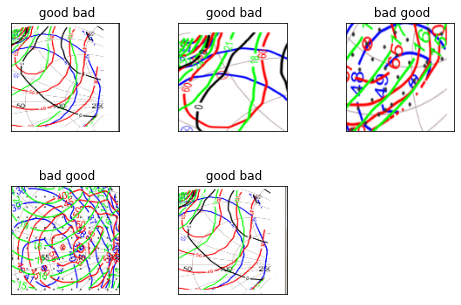

In [106]:
#Fine-tuned Pre-trained CNN preds
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1 , figsize = (8 , 8))
n = 0 
m = 0
#for i in range(358):
for i in range(110):
    n += 1 
    r = np.random.randint(0 , test_data.shape[0] , 1)
    #if test_labels[r[0]] != basic_cnn_pred_labels[r[0]] :
    if test_labels[r[0]] != vgg_ft_pred_labels[r[0]] :    
        m += 1 
        plt.subplot(3 , 3 , m)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
        plt.imshow(test_data[r[0]]/255.)
    #plt.title('{}'.format(test_labels[r[0]]))
    #plt.title('{}'.format(test_labels[r[0]] +  vgg_ft_pred_labels[r[0]]))
        #plt.title('{}'.format(test_labels[r[0]] + basic_cnn_pred_labels[r[0]] ))
        plt.title('{}'.format(test_labels[r[0]] + vgg_ft_pred_labels[r[0]] ))
    #vgg_ft_pred_labels
        plt.xticks([]) , plt.yticks([])
print (m)

4


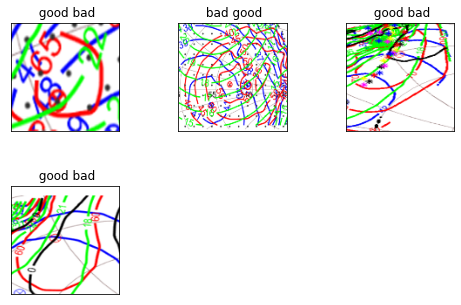

In [107]:
#basic_cnn_preds
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1 , figsize = (8 , 8))
n = 0 
m = 0
#for i in range(358):
for i in range(110):
    n += 1 
    r = np.random.randint(0 , test_data.shape[0] , 1)
    #if test_labels[r[0]] != basic_cnn_pred_labels[r[0]] :
    if test_labels[r[0]] != vgg_frz_pred_labels[r[0]] :    
        m += 1 
        plt.subplot(3 , 3 , m)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
        plt.imshow(test_data[r[0]]/255.)
    #plt.title('{}'.format(test_labels[r[0]]))
    #plt.title('{}'.format(test_labels[r[0]] +  vgg_ft_pred_labels[r[0]]))
        #plt.title('{}'.format(test_labels[r[0]] + basic_cnn_pred_labels[r[0]] ))
        plt.title('{}'.format(test_labels[r[0]] + vgg_frz_pred_labels[r[0]] ))
    #vgg_ft_pred_labels
        plt.xticks([]) , plt.yticks([])
print (m)

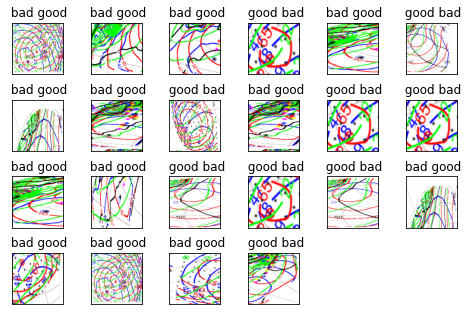

In [108]:
#Frozen Pre-trained CNN preds
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1 , figsize = (8 , 8))
n = 0 
m = 0
for i in range(110):
    n += 1 
    r = np.random.randint(0 , test_data.shape[0] , 1)
    if test_labels[r[0]] != basic_cnn_pred_labels[r[0]] :
    #if test_labels[r[0]] != vgg_ft_pred_labels[r[0]] :    
        m += 1 
        plt.subplot(6 , 6 , m)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
        plt.imshow(test_data[r[0]]/255.)
    #plt.title('{}'.format(test_labels[r[0]]))
    #plt.title('{}'.format(test_labels[r[0]] +  vgg_ft_pred_labels[r[0]]))
        plt.title('{}'.format(test_labels[r[0]] + basic_cnn_pred_labels[r[0]] ))
        #plt.title('{}'.format(test_labels[r[0]] + vgg_ft_pred_labels[r[0]] ))
   
        plt.xticks([]) , plt.yticks([])

In [109]:
print('Pred:', Counter(basic_cnn_pred_labels), '\nTruth:', Counter(test_labels))

Pred: Counter({' good': 64, ' bad': 46}) 
Truth: Counter({' good': 58, ' bad': 52})


In [110]:
print('Pred:', Counter(vgg_frz_pred_labels), '\nTruth:', Counter(test_labels))

Pred: Counter({' bad': 55, ' good': 55}) 
Truth: Counter({' good': 58, ' bad': 52})


In [111]:
print('Pred:', Counter(vgg_ft_pred_labels), '\nTruth:', Counter(test_labels))

Pred: Counter({' good': 56, ' bad': 54}) 
Truth: Counter({' good': 58, ' bad': 52})
